In [331]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.optimize import minimize
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score
import lightgbm as lgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [290]:
df_train = pd.read_csv('../input/child-mind-institute-problematic-internet-use/train.csv')

print(df_train.head().to_markdown(index=False, numalign='left', stralign='left'))

print(df_train.info())

| id       | Basic_Demos-Enroll_Season   | Basic_Demos-Age   | Basic_Demos-Sex   | CGAS-Season   | CGAS-CGAS_Score   | Physical-Season   | Physical-BMI   | Physical-Height   | Physical-Weight   | Physical-Waist_Circumference   | Physical-Diastolic_BP   | Physical-HeartRate   | Physical-Systolic_BP   | Fitness_Endurance-Season   | Fitness_Endurance-Max_Stage   | Fitness_Endurance-Time_Mins   | Fitness_Endurance-Time_Sec   | FGC-Season   | FGC-FGC_CU   | FGC-FGC_CU_Zone   | FGC-FGC_GSND   | FGC-FGC_GSND_Zone   | FGC-FGC_GSD   | FGC-FGC_GSD_Zone   | FGC-FGC_PU   | FGC-FGC_PU_Zone   | FGC-FGC_SRL   | FGC-FGC_SRL_Zone   | FGC-FGC_SRR   | FGC-FGC_SRR_Zone   | FGC-FGC_TL   | FGC-FGC_TL_Zone   | BIA-Season   | BIA-BIA_Activity_Level_num   | BIA-BIA_BMC   | BIA-BIA_BMI   | BIA-BIA_BMR   | BIA-BIA_DEE   | BIA-BIA_ECW   | BIA-BIA_FFM   | BIA-BIA_FFMI   | BIA-BIA_FMI   | BIA-BIA_Fat   | BIA-BIA_Frame_num   | BIA-BIA_ICW   | BIA-BIA_LDM   | BIA-BIA_LST   | BIA-BIA_SMM   | BIA-BIA_TBW   | PAQ_A-Seas

<Axes: >

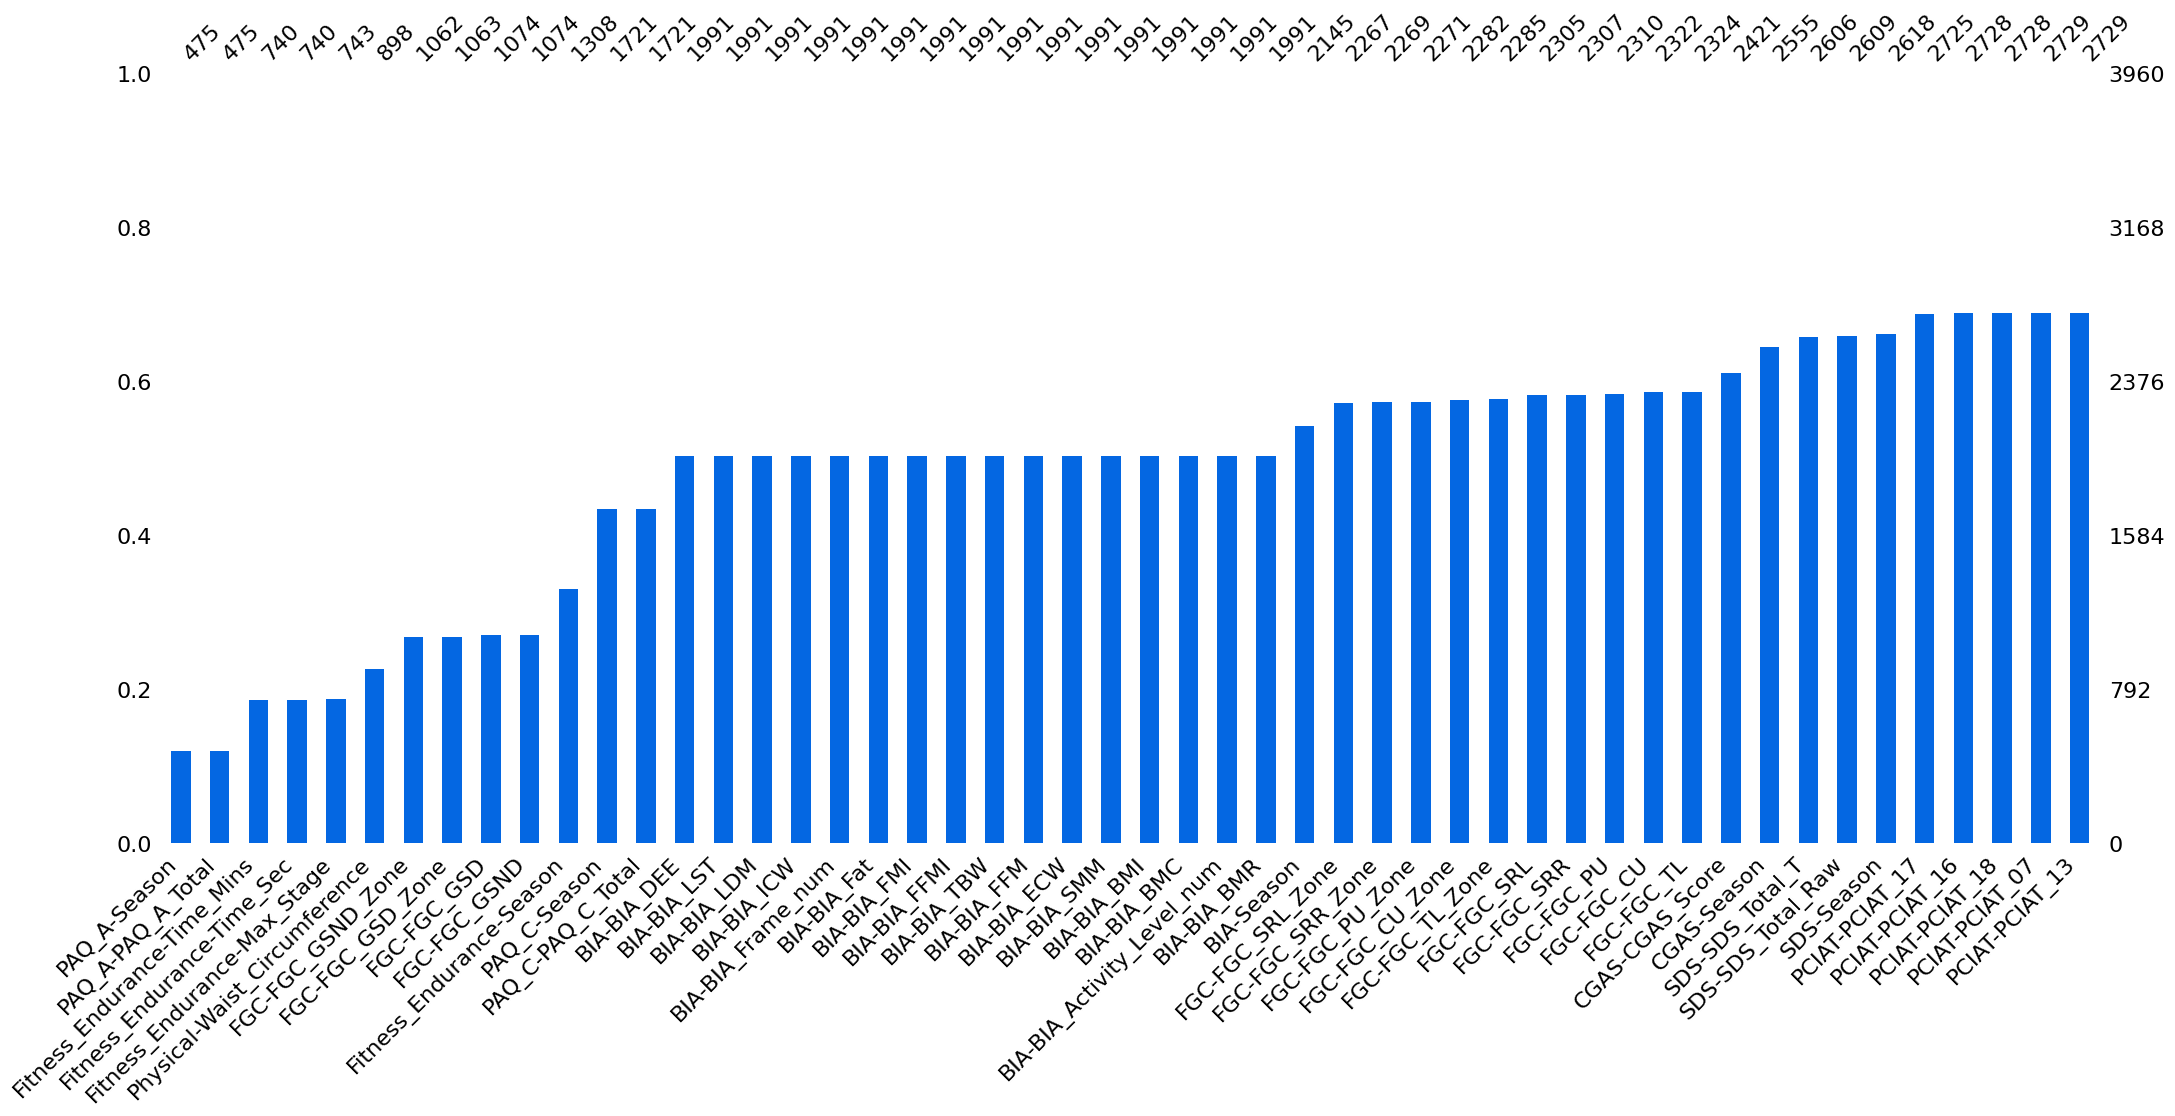

In [291]:
msno.bar(df_train, filter='bottom', n=50, p=0.999, sort='ascending', color='#0467e2')

<Axes: >

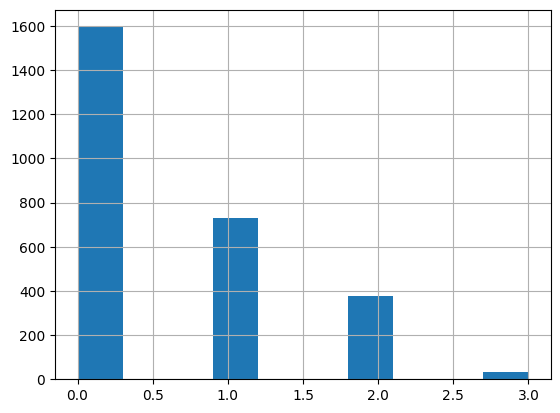

In [292]:
df_train['sii'].hist()

In [293]:
pd.crosstab(df_train['PAQ_A-Season'], df_train['sii'])

sii,0.0,1.0,2.0,3.0
PAQ_A-Season,,,,
Fall,26,22,24,6
Spring,31,37,19,3
Summer,40,32,25,0
Winter,34,28,32,4


In [294]:
pd.crosstab(df_train['PAQ_C-Season'], df_train['sii'])

sii,0.0,1.0,2.0,3.0
PAQ_C-Season,,,,
Fall,162,101,42,3
Spring,213,139,48,5
Summer,201,91,46,4
Winter,191,111,78,5


Looking at the above tables, it seems like we can exclude 'PAQ_C-Season' and 'PAQ_A-Season' for prediction as per the univariate analysis

In [295]:
import matplotlib.pyplot as plt

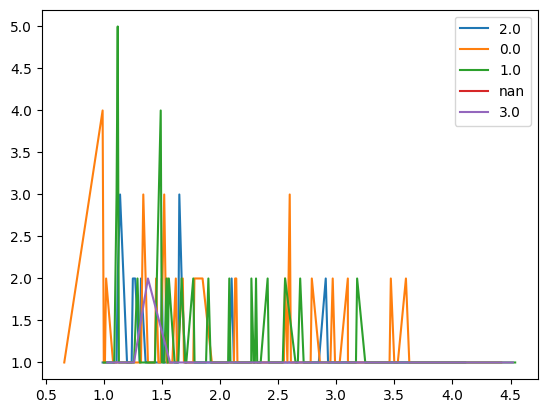

In [296]:
for siiu in df_train['sii'].unique():
    x = df_train[df_train['sii']==siiu]['PAQ_A-PAQ_A_Total'].value_counts().sort_index()
    plt.plot(x.index, x.values, label=siiu)

plt.legend()
plt.show()

In [297]:
df_train[(~df_train['PAQ_A-PAQ_A_Total'].isna()) & (~df_train['PAQ_C-PAQ_C_Total'].isna())]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
3331,d74e4d7c,Winter,13,1,NaN,NaN,Summer,24.094889,68.75,162.0,NaN,70.0,62.0,118.0,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.27,Spring,2.32,Spring,5.0,4.0,4.0,1.0,5.0,1.0,0.0,2.0,1.0,2.0,3.0,0.0,3.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,45.0,Winter,52.0,72.0,Winter,3.0,1.0


In [298]:
df_train[~df_train['PAQ_C-PAQ_C_Total'].isna()]['Basic_Demos-Age'].min(), df_train[~df_train['PAQ_C-PAQ_C_Total'].isna()]['Basic_Demos-Age'].max()

(7, 17)

In [299]:
len(df_train[(~df_train['PAQ_C-PAQ_C_Total'].isna()) & (df_train['Basic_Demos-Age']>=13)])

269

In [300]:
import seaborn as sns

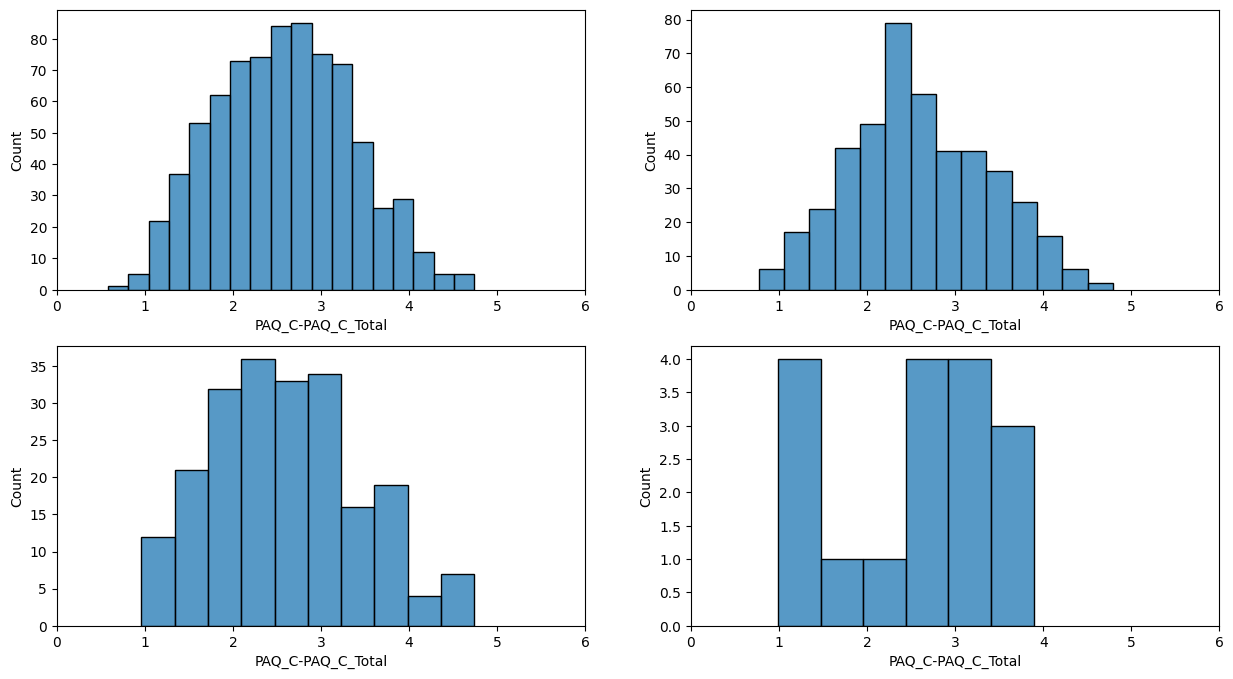

In [301]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(data=df_train[df_train['sii']==0], x='PAQ_C-PAQ_C_Total', ax=ax[0, 0])
sns.histplot(data=df_train[df_train['sii']==1], x='PAQ_C-PAQ_C_Total', ax=ax[0, 1])
sns.histplot(data=df_train[df_train['sii']==2], x='PAQ_C-PAQ_C_Total', ax=ax[1, 0])
sns.histplot(data=df_train[df_train['sii']==3], x='PAQ_C-PAQ_C_Total', ax=ax[1, 1])

ax[0, 0].set_xlim((0, 6))
ax[0, 1].set_xlim((0, 6))
ax[1, 0].set_xlim((0, 6))
ax[1, 1].set_xlim((0, 6))
plt.show()

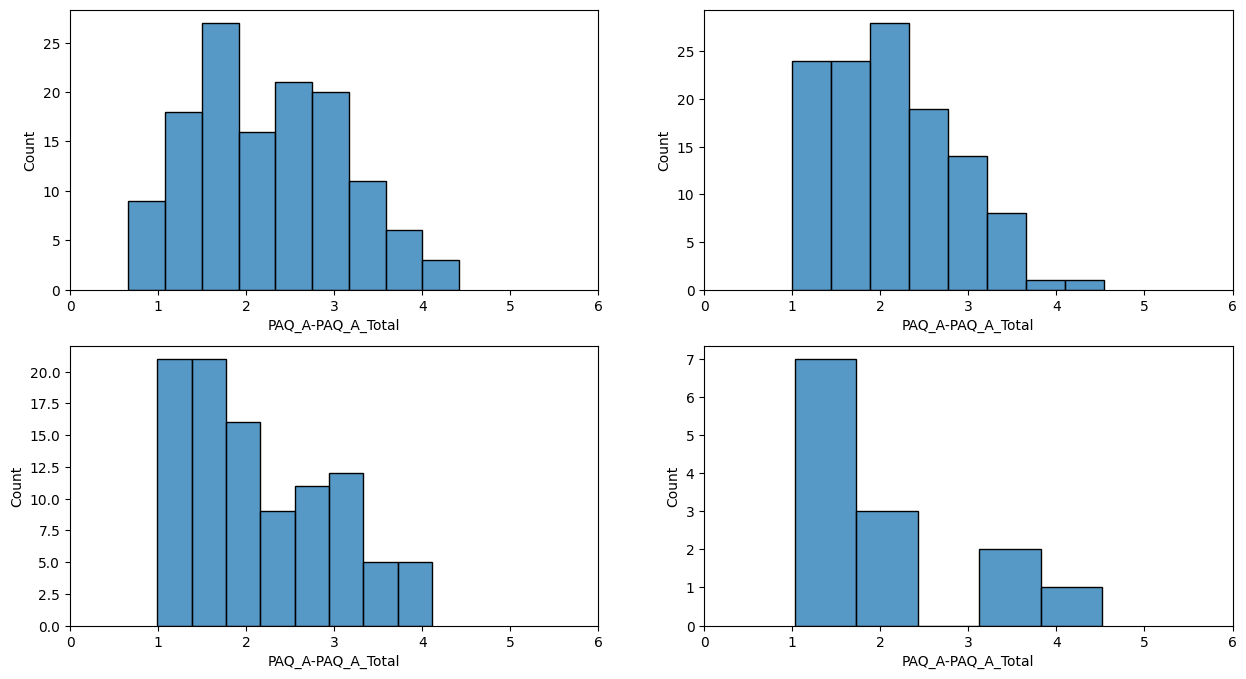

In [302]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(data=df_train[df_train['sii']==0], x='PAQ_A-PAQ_A_Total', ax=ax[0, 0])
sns.histplot(data=df_train[df_train['sii']==1], x='PAQ_A-PAQ_A_Total', ax=ax[0, 1])
sns.histplot(data=df_train[df_train['sii']==2], x='PAQ_A-PAQ_A_Total', ax=ax[1, 0])
sns.histplot(data=df_train[df_train['sii']==3], x='PAQ_A-PAQ_A_Total', ax=ax[1, 1])

ax[0, 0].set_xlim((0, 6))
ax[0, 1].set_xlim((0, 6))
ax[1, 0].set_xlim((0, 6))
ax[1, 1].set_xlim((0, 6))
plt.show()

In [303]:
df_train[['PAQ_C-PAQ_C_Total', 'sii']].corr(method='kendall')

,PAQ_C-PAQ_C_Total,sii
PAQ_C-PAQ_C_Total,1.000000,0.000504
sii,0.000504,1.000000


In [304]:
df_train[~df_train['PAQ_A-PAQ_A_Total'].isna()]['Basic_Demos-Age'].min(), df_train[~df_train['PAQ_A-PAQ_A_Total'].isna()]['Basic_Demos-Age'].max()

(13, 18)

I think we can remove this difference of children and adolescent, consider an error +- 0.05 and use only single column for PAQ

<Axes: >

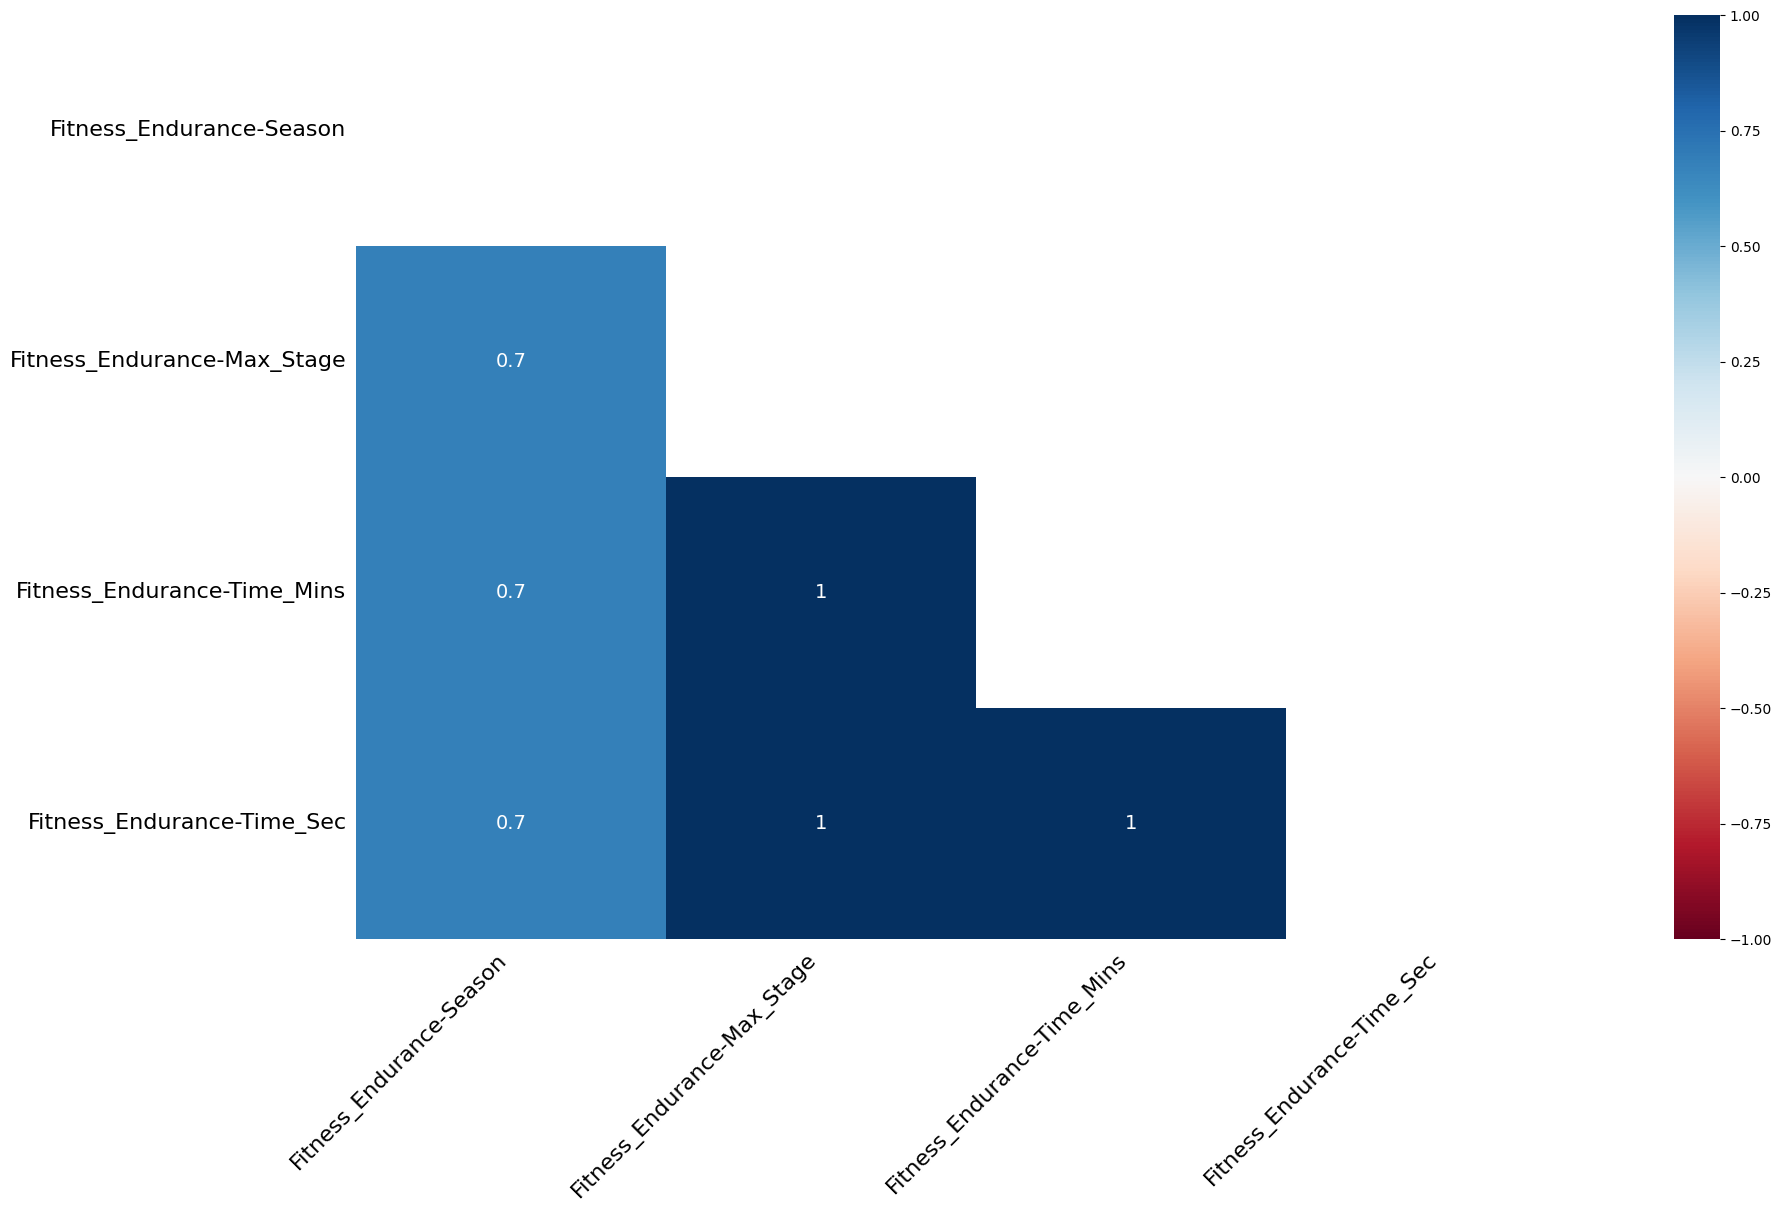

In [305]:
msno.heatmap(df_train[[col for col in df_train.columns if col.startswith('Fitness')]])

Why season have more values than fitness endurance? Is reporting delayed from time of recording?

Just make a new column adding mins and sec in sec for Fitness Endurance Test

In [306]:
df_train['Fitness_Endurance-Max_Stage'].value_counts()

Fitness_Endurance-Max_Stage
5.0     213
6.0     179
4.0     125
7.0      74
3.0      57
2.0      53
1.0      17
8.0      12
12.0      4
9.0       3
10.0      2
0.0       1
26.0      1
11.0      1
28.0      1
Name: count, dtype: int64

In [307]:
pd.crosstab(df_train['Fitness_Endurance-Season'], df_train['Fitness_Endurance-Max_Stage'], values=df_train['sii'], aggfunc=lambda x:(x==1).sum())

Fitness_Endurance-Max_Stage,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,26.0,28.0
Fitness_Endurance-Season,,,,,,,,,,,,,,,
Fall,0.0,2.0,4.0,6.0,5.0,14.0,16.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
Spring,NaN,1.0,1.0,4.0,15.0,11.0,11.0,2.0,1.0,NaN,NaN,NaN,1.0,NaN,0.0
Summer,NaN,1.0,0.0,6.0,6.0,16.0,10.0,4.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
Winter,NaN,1.0,4.0,1.0,6.0,14.0,11.0,1.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN


Again season doesn't seem to play a role

<Axes: xlabel='Physical-Waist_Circumference', ylabel='Count'>

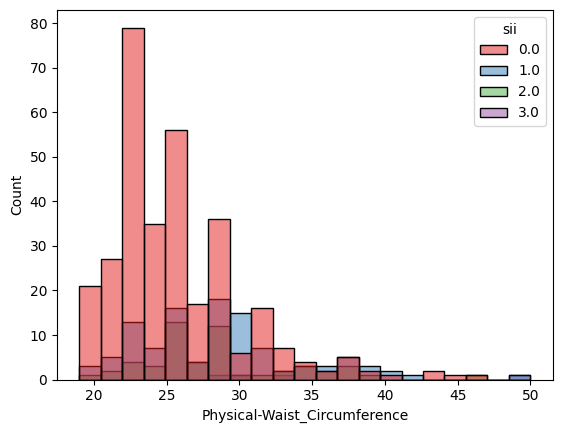

In [308]:
sns.histplot(data=df_train, x='Physical-Waist_Circumference', hue='sii', palette='Set1')

<Axes: >

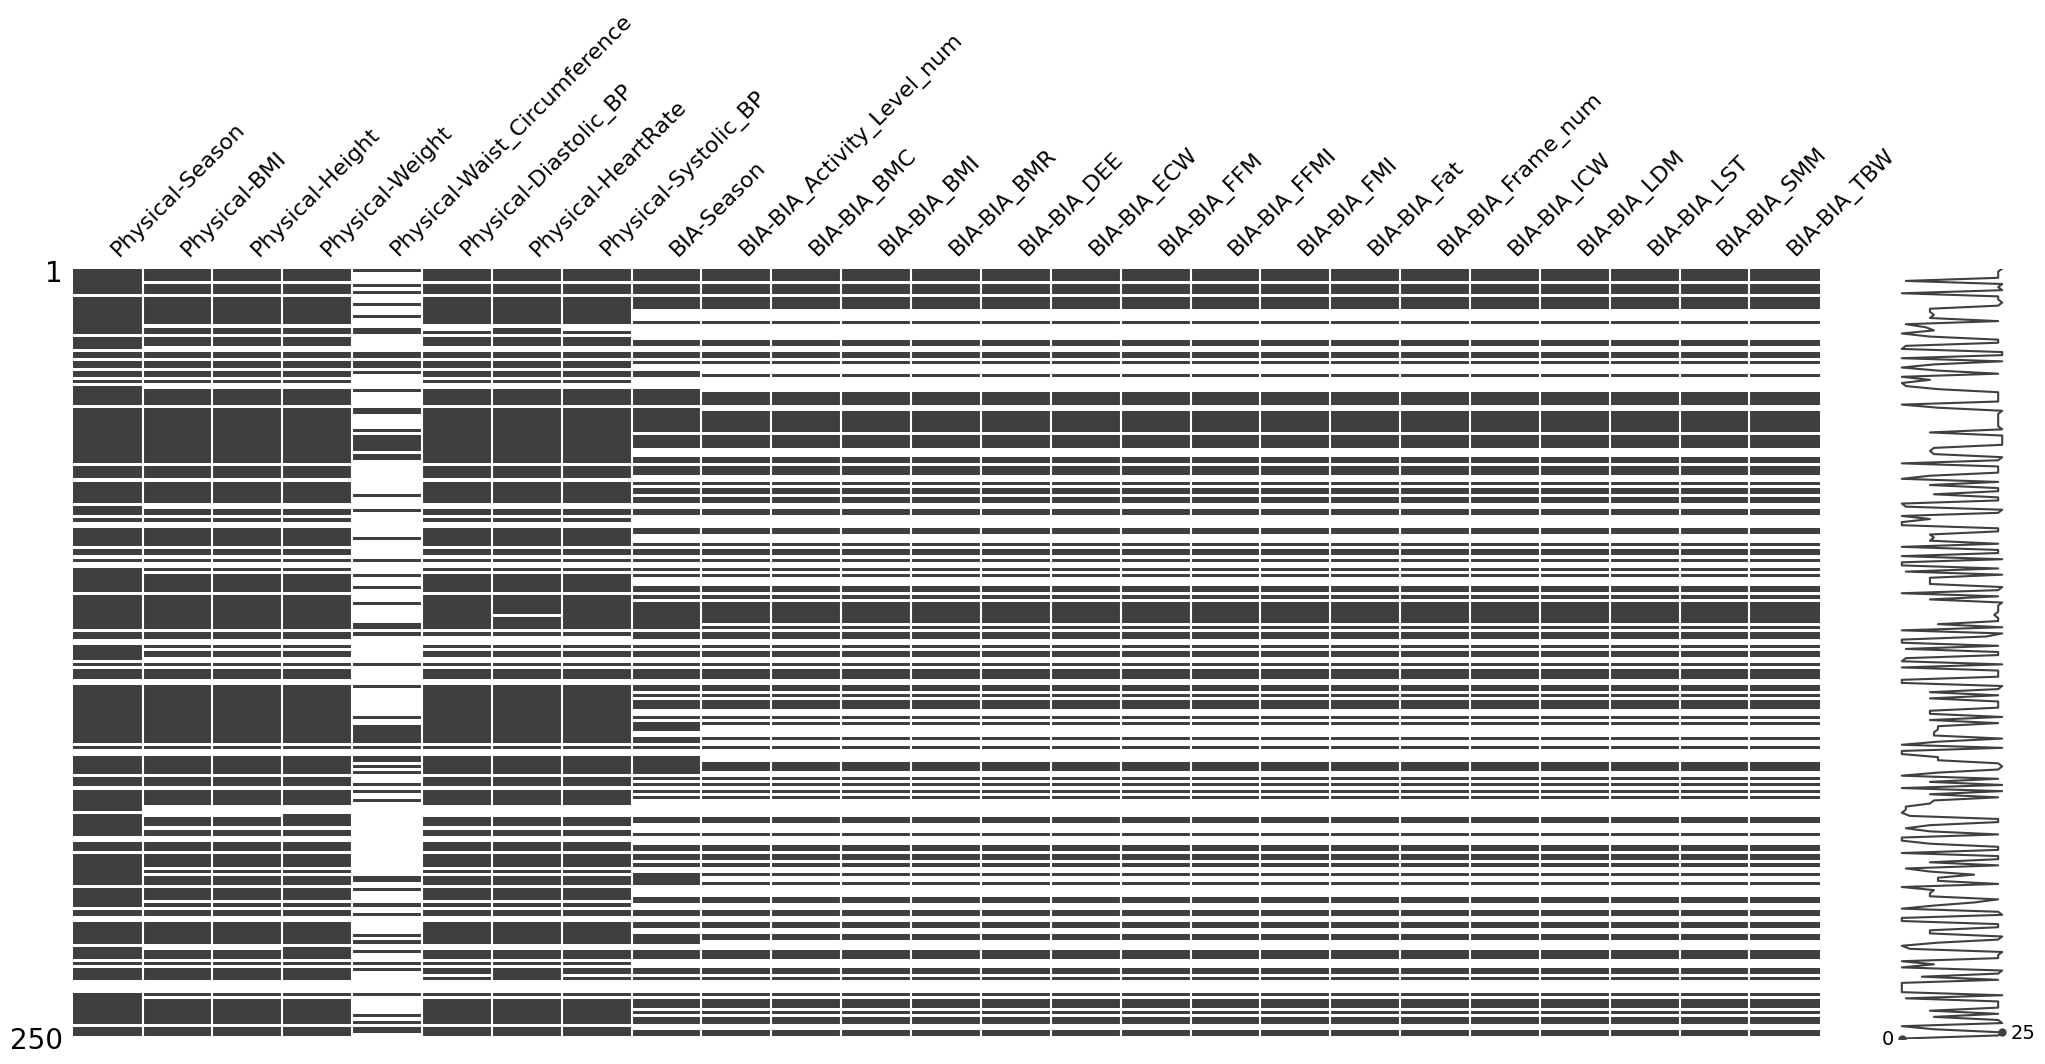

In [309]:
physical_cols = [col for col in df_train.columns if col.startswith('Physical')]
bia_cols = [col for col in df_train.columns if col.startswith('BIA')]
msno.matrix(df_train[physical_cols + bia_cols].sample(250))

<Axes: xlabel='BIA-BIA_BMR', ylabel='BIA-BIA_TBW'>

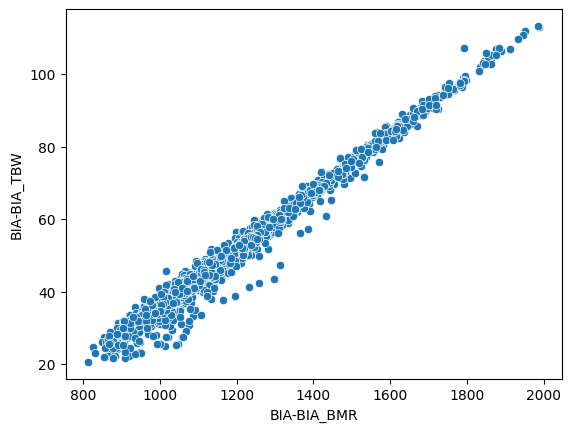

In [310]:
sns.scatterplot(data=df_train[df_train['BIA-BIA_BMR']<2000], x='BIA-BIA_BMR', y='BIA-BIA_TBW')

In [311]:
# sns.heatmap(df_train.corr())

In [312]:
print(len(df_train))
df_train = df_train.dropna(subset=['sii'])
print(len(df_train))

3960
2736


In [313]:
X = df_train.drop('sii', axis=1).reset_index(drop=True)
y = df_train['sii'].reset_index(drop=True)

In [314]:
def feature_enginnering(df, training=True):
    df['PAQ_Total'] = np.nan
    mask = (~df['PAQ_C-PAQ_C_Total'].isna()) | (~df['PAQ_A-PAQ_A_Total'].isna())
    df.loc[mask, 'PAQ_Total'] = (df.loc[mask, 'PAQ_C-PAQ_C_Total'].fillna(0) + df.loc[mask, 'PAQ_A-PAQ_A_Total'].fillna(0)) / 2

    df['Fitness_Endurance_Duration'] = df['Fitness_Endurance-Time_Mins'] * 60 + df['Fitness_Endurance-Time_Sec']
    
    # Remove all season and pciat cols
    season_cols = [col for col in df.columns if col.endswith('Season')]
    pciat_cols = [col for col in df.columns if col.startswith('PCIAT')]
    df = df.drop(pciat_cols + season_cols + ['id',
                  'PAQ_C-PAQ_C_Total', 'PAQ_A-PAQ_A_Total', 'Fitness_Endurance-Time_Mins', 
                  'Fitness_Endurance-Time_Sec'], axis=1)
    
    if training:
        # imputer = IterativeImputer(
        #     n_nearest_features=len(physical_cols)+len(bia_cols),
        #     skip_complete=True,
        #     random_state=42,
        #     verbose=1
        # )
        imputer = KNNImputer(n_neighbors=10, add_indicator=True)
        df = pd.DataFrame(imputer.fit_transform(df), columns=imputer.get_feature_names_out())
    else:
        # TODO: save load artifact
        pass

    keep_only_indicators = [
        'missingindicator_Physical-Waist_Circumference',
        'missingindicator_FGC-FGC_PU',
        'missingindicator_CGAS-CGAS_Score',
        'missingindicator_Fitness_Endurance-Max_Stage',
        'missingindicator_BIA-BIA_Activity_Level_num',
        'missingindicator_FGC-FGC_GSND',
        'missingindicator_PAQ_Total',
        'missingindicator_FGC-FGC_CU',
        'missingindicator_FGC-FGC_PU_Zone',
        'missingindicator_PreInt_EduHx-computerinternet_hoursday',
    ]
    missing_indicator_cols = [col for col in df.columns if col.startswith('missingindicator') and col not in keep_only_indicators]
    df.drop(missing_indicator_cols, axis=1)


    return df

In [315]:
X = feature_enginnering(X)

In [316]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [317]:
def roundoff(arr, thresholds=[0.5, 1.5, 2.5]):
    return np.where(arr < thresholds[0], 0, 
                np.where(arr < thresholds[1], 1, 
                    np.where(arr < thresholds[2], 2, 3)))

In [318]:
def evaluate(thresholds, y_true, y_pred):
    score = quadratic_weighted_kappa(y_true, roundoff(y_pred, thresholds))
    return -score

In [319]:
skf = StratifiedKFold()

scores = []
oof_raw = np.zeros(len(y), dtype=float) # oof predictions, before rounding
oof = np.zeros(len(y), dtype=int) # oof predictions, rounded
for fold, (tridx, validx) in enumerate(skf.split(X, y)):
    # model = XGBRegressor()
    # model = CatBoostRegressor(silent=True, allow_writing_files=False)
    model = lgb.LGBMRegressor(class_weight='balanced', verbose=-1)
    model.fit(X.loc[tridx], y.loc[tridx])
    
    y_pred = model.predict(X.loc[validx])
    oof_raw[validx] = y_pred
    y_pred = roundoff(y_pred, thresholds=[0.49120744, 1.35878992, 2.65786462])
    oof[validx] = y_pred

    score = quadratic_weighted_kappa(y.loc[validx], y_pred)
    scores.append(score)

    accuracy = accuracy_score(y.loc[validx], y_pred)
    print(f"Fold: {fold}, Score: {score:.6f}, Accuracy: {accuracy:.6f}")
    print("-"*40)

print(f"Mean score: {np.mean(scores)}")
score = quadratic_weighted_kappa(y, oof)
print(f"OOF score: {score}")

thresholds = minimize(evaluate, [0.5, 1.5, 2.5], args=(y, oof_raw), method='Nelder-Mead').x
print('Thresholds', thresholds)

y_pred_tuned = roundoff(oof_raw, thresholds=thresholds)
print("Tuned OOF Score:", quadratic_weighted_kappa(y, y_pred_tuned))

Fold: 0, Score: 0.346826, Accuracy: 0.479927
----------------------------------------
Fold: 1, Score: 0.395757, Accuracy: 0.521024
----------------------------------------
Fold: 2, Score: 0.389407, Accuracy: 0.486289
----------------------------------------
Fold: 3, Score: 0.420398, Accuracy: 0.544790
----------------------------------------
Fold: 4, Score: 0.330401, Accuracy: 0.488117
----------------------------------------
Mean score: 0.3765577458003698
OOF score: 0.37685405265970195
Thresholds [0.67088539 1.23593149 1.9805093 ]
Tuned OOF Score: 0.42609322363596924


In [320]:
fi = []
for feat, imp in zip(model.feature_names_in_, model.feature_importances_):
    fi.append((feat, imp))
sorted(fi, key=lambda x:x[1], reverse=True)

[('PAQ_Total', 149),
 ('FGC-FGC_GSND', 120),
 ('SDS-SDS_Total_Raw', 120),
 ('Physical-HeartRate', 118),
 ('FGC-FGC_PU', 117),
 ('FGC-FGC_GSD', 108),
 ('Fitness_Endurance_Duration', 108),
 ('Physical-Systolic_BP', 102),
 ('BIA-BIA_BMC', 101),
 ('CGAS-CGAS_Score', 99),
 ('FGC-FGC_CU', 90),
 ('BIA-BIA_LDM', 85),
 ('Physical-Height', 84),
 ('BIA-BIA_FFMI', 84),
 ('Physical-Waist_Circumference', 79),
 ('FGC-FGC_SRR', 78),
 ('FGC-FGC_TL', 76),
 ('BIA-BIA_DEE', 76),
 ('BIA-BIA_ICW', 73),
 ('BIA-BIA_Fat', 72),
 ('PreInt_EduHx-computerinternet_hoursday', 72),
 ('Physical-Diastolic_BP', 71),
 ('BIA-BIA_SMM', 70),
 ('BIA-BIA_FMI', 67),
 ('BIA-BIA_ECW', 64),
 ('FGC-FGC_SRL', 62),
 ('Fitness_Endurance-Max_Stage', 61),
 ('Physical-BMI', 59),
 ('BIA-BIA_BMI', 52),
 ('BIA-BIA_LST', 40),
 ('Basic_Demos-Age', 37),
 ('BIA-BIA_Frame_num', 36),
 ('FGC-FGC_GSND_Zone', 35),
 ('BIA-BIA_Activity_Level_num', 34),
 ('Physical-Weight', 33),
 ('BIA-BIA_BMR', 31),
 ('BIA-BIA_TBW', 31),
 ('FGC-FGC_CU_Zone', 25),
 ('

<Axes: >

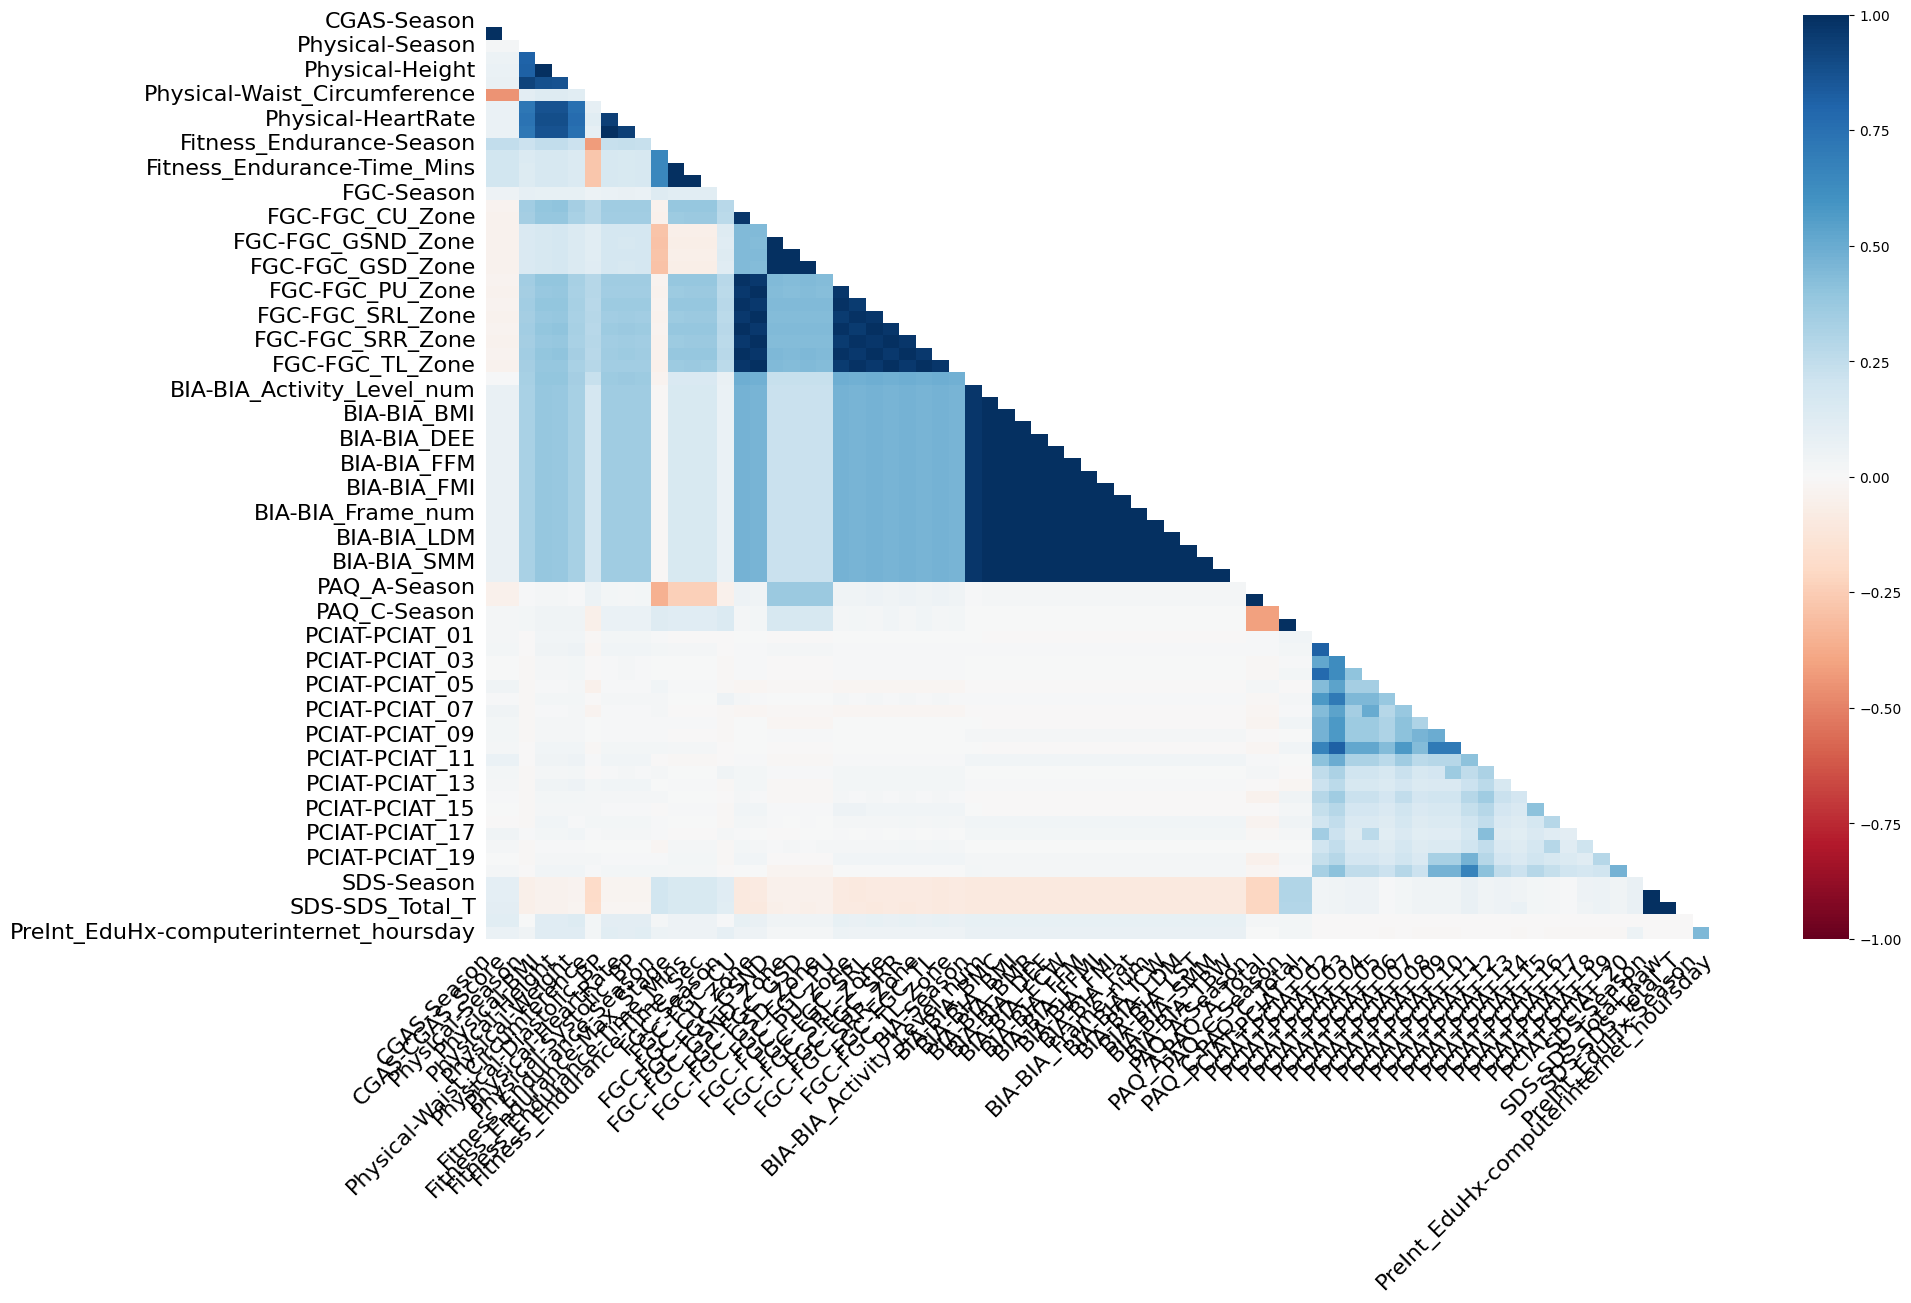

In [321]:
msno.heatmap(df_train, labels=False)